In [2]:
# Read and understand the data
import pandas as pd
df = pd.read_csv("data/AD_data_10KPI.csv", parse_dates=['Date'])

features = [
    "RSRP", "DL_Throughput", "Call_Drop_Rate", "RTT",
    "CPU_Utilization", "Active_Users", "SINR",
    "UL_Throughput", "Handover_Success_Rate", "Packet_Loss"
]

print(df.shape)
print(df.dtypes)
print(f'From {df["Date"].min()} To {df["Date"].max()}')
print(df["Site_ID"].nunique(), "unique sites")
print(df["Sector_ID"].nunique(), "unique sectors")

(21060, 13)
Date                     datetime64[ns]
Site_ID                          object
Sector_ID                        object
RSRP                            float64
DL_Throughput                   float64
Call_Drop_Rate                  float64
RTT                             float64
CPU_Utilization                 float64
Active_Users                    float64
SINR                            float64
UL_Throughput                   float64
Handover_Success_Rate           float64
Packet_Loss                     float64
dtype: object
From 2024-01-01 00:00:00 To 2024-02-29 00:00:00
100 unique sites
351 unique sectors


In [3]:
# check data statistics
df[features].describe()

,RSRP,DL_Throughput,Call_Drop_Rate,RTT,CPU_Utilization,Active_Users,SINR,UL_Throughput,Handover_Success_Rate,Packet_Loss
count,21060.000000,21060.000000,21060.000000,21060.000000,21060.000000,21060.000000,21060.000000,21060.000000,21060.000000,21060.000000
mean,-97.376181,56.168821,2.930911,26.400632,52.777571,583.164028,10.422765,29.954624,95.381394,1.723311
std,49.149994,37.739920,2.342453,21.819920,28.963308,383.623587,16.343734,26.004931,47.189613,1.592921
min,-2976.942068,-502.592078,-21.446340,-216.189820,-155.640426,-6337.845385,-284.736289,-214.105998,-2375.430709,-27.937603
25%,-108.221321,30.912114,1.329165,12.224171,35.499689,343.814296,0.220901,17.342528,88.450123,0.707121
50%,-95.352451,54.207213,2.718754,25.682195,51.261133,568.258266,10.461067,29.134001,92.517856,1.551998
75%,-81.561774,78.746875,4.204809,38.485433,66.491492,801.054697,20.082557,40.209679,96.440634,2.516935
max,273.442989,796.769299,60.349193,564.395257,515.020277,4489.936008,216.149783,1172.518582,1187.055816,43.280950


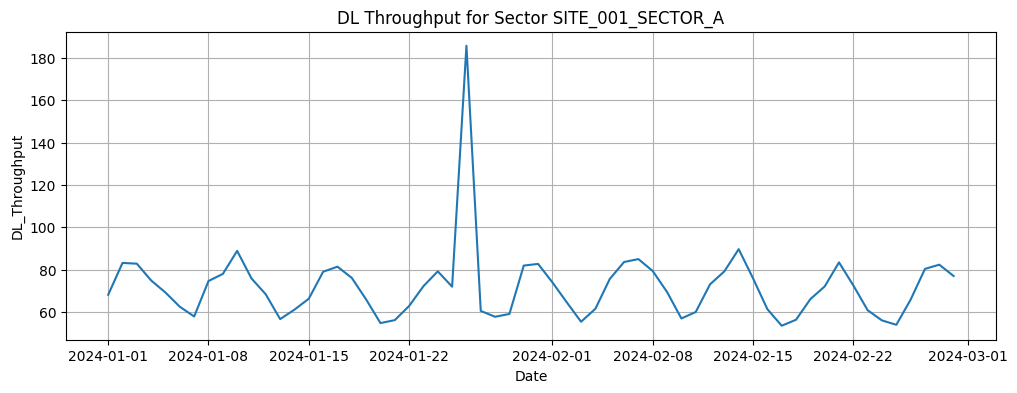

In [4]:
#plot example KPI for one sector
import matplotlib.pyplot as plt

sample_sector = 'SITE_001_SECTOR_A'
sample_KPI = 'DL_Throughput'
df_sample = df[df["Sector_ID"] == sample_sector].sort_values("Date")

plt.figure(figsize=(12, 4))
plt.plot(df_sample["Date"], df_sample[sample_KPI])
plt.title(f"DL Throughput for Sector {sample_sector}")
plt.xlabel("Date")
plt.ylabel("DL_Throughput")
plt.grid(True)
plt.show()

In [5]:
# check for missing values
missing = df.isnull().sum()
print(missing)

Date                     0
Site_ID                  0
Sector_ID                0
RSRP                     0
DL_Throughput            0
Call_Drop_Rate           0
RTT                      0
CPU_Utilization          0
Active_Users             0
SINR                     0
UL_Throughput            0
Handover_Success_Rate    0
Packet_Loss              0
dtype: int64


In [6]:
# Detect outliers based on domain knowledge

df = df[(df['RSRP'] >= -140) & (df['RSRP'] <= -44)]
df = df[df['DL_Throughput'] >= 0]
df = df[(df['Call_Drop_Rate'] >= 0) & (df['Call_Drop_Rate'] <= 100)]
df = df[(df['RTT'] >= 0) & (df['RTT'] <= 1000)]
df = df[(df['CPU_Utilization'] >= 0) & (df['CPU_Utilization'] <= 100)]
df = df[(df['Active_Users'] >= 0)]
df = df[(df['SINR'] >= -20) & (df['SINR'] <= 35)]
df = df[df['UL_Throughput'] >= 0]
df = df[(df['Handover_Success_Rate'] >= 0) & (df['Handover_Success_Rate'] <= 100)]
df = df[(df['Packet_Loss'] >= 0) & (df['Packet_Loss'] <= 10)]


In [7]:
# normalize per-sector per-KPI to preserve local behavior
from sklearn.preprocessing import StandardScaler
df_scaled = pd.DataFrame()

for sector_id, group in df.groupby('Sector_ID'):
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(group[features])
    
    group_scaled = group.copy()
    group_scaled[features] = scaled_values
    
    df_scaled = pd.concat([df_scaled, group_scaled])

#sort to preserve time order within each sector
df_scaled = df_scaled.sort_values(['Sector_ID', 'Date'])

df_scaled.head()

,Date,Site_ID,Sector_ID,RSRP,DL_Throughput,Call_Drop_Rate,RTT,CPU_Utilization,Active_Users,SINR,UL_Throughput,Handover_Success_Rate,Packet_Loss
0,2024-01-01,SITE_001,SITE_001_SECTOR_A,0.150880,-0.260707,-0.510968,-0.152086,0.124837,-0.083472,0.006781,-0.120406,0.235355,0.896311
1,2024-01-02,SITE_001,SITE_001_SECTOR_A,1.432102,1.247497,0.893886,0.021473,0.621640,0.938360,0.891814,0.458000,0.301889,0.907634
2,2024-01-03,SITE_001,SITE_001_SECTOR_A,1.169882,1.211906,-0.006759,0.158765,0.957244,1.207229,1.816099,0.937611,0.301889,1.203062
3,2024-01-04,SITE_001,SITE_001_SECTOR_A,0.751887,0.415148,0.533509,-0.210988,0.850465,0.335440,0.727518,0.624939,0.301889,1.034476
4,2024-01-05,SITE_001,SITE_001_SECTOR_A,-0.760508,-0.155865,-0.789177,-0.427450,0.400776,-0.133951,-0.279707,-1.071133,0.204121,0.135063


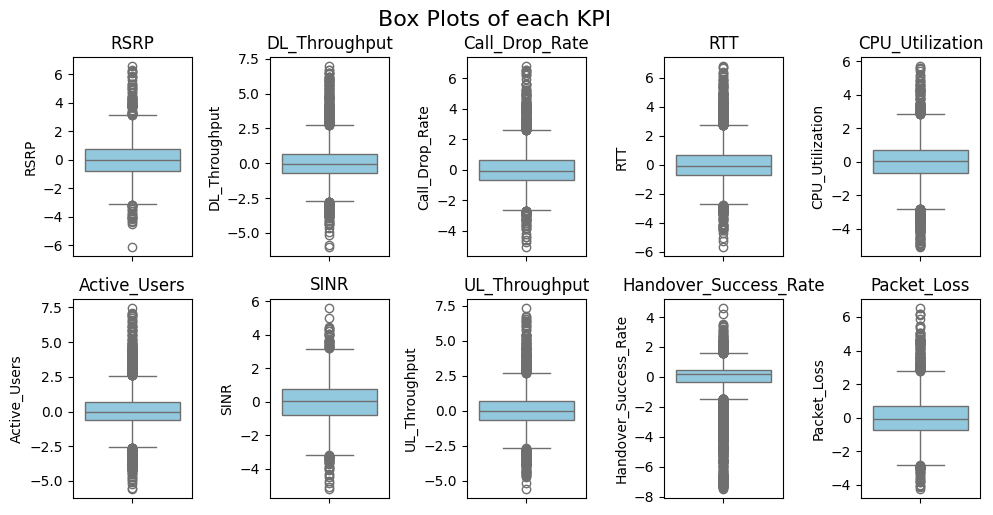

In [8]:
#box plot for each KPI 
import seaborn as sns

plt.figure(figsize=(10, 5))
for i, col in enumerate(features):
    plt.subplot(2, 5, i + 1)
    sns.boxplot(y=df_scaled[col], color='skyblue')
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Box Plots of each KPI", y=1.02, fontsize=16)
plt.show()

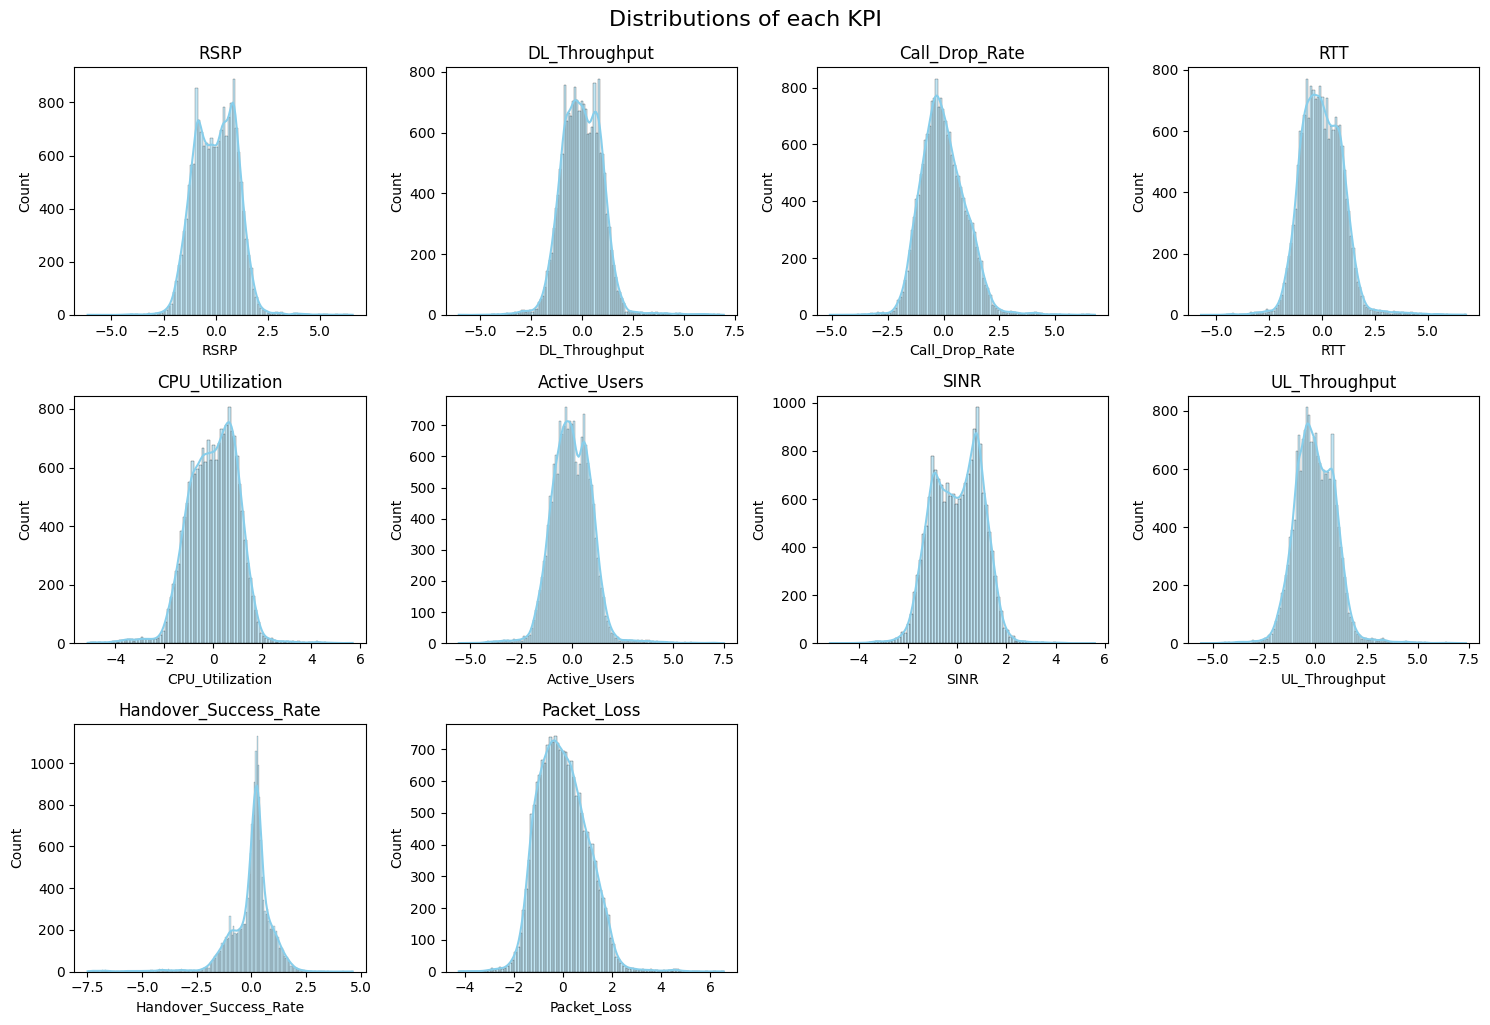

In [9]:
# Visualize distributions for each KPI
plt.figure(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(3, 4, i + 1)
    #sns.distplot(x=df[col], kde=True, color='skyblue')
    sns.histplot(x=df_scaled[col], color='skyblue', kde=True)
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Distributions of each KPI", y=1.02, fontsize=16)
plt.show()

In [10]:
# Compute skewness and kurtosis for each KPI
from scipy.stats import skew, kurtosis

dist_summary = []
for kpi in features:
    sk = skew(df_scaled[kpi])
    kt = kurtosis(df_scaled[kpi])

    dist_summary.append({
        "KPI": kpi,
        "Skewness": round(sk, 2),
        "Kurtosis": round(kt, 2),
    })

distribution_df = pd.DataFrame(dist_summary)
distribution_df


,KPI,Skewness,Kurtosis
0,RSRP,0.18,0.90
1,DL_Throughput,0.50,3.46
2,Call_Drop_Rate,0.63,2.09
3,RTT,0.58,2.98
4,CPU_Utilization,-0.25,1.63
5,Active_Users,0.45,3.95
6,SINR,-0.11,-0.04
7,UL_Throughput,0.50,3.11
8,Handover_Success_Rate,-2.29,11.62
9,Packet_Loss,0.48,1.10


In [ ]:
import numpy as np
from sklearn.model_selection import ParameterGrid
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.auto_encoder import AutoEncoder

# Define models and grid search parameters
model_configs = {
    'IsolationForest': {
        'model': IForest,
        'params': {
            'n_estimators': [100, 200],
            'max_samples': ['auto', 0.8],
            'contamination': [0.05, 0.1]
        }
    },
    'KNN': {
        'model': KNN,
        'params': {
            'n_neighbors': [5, 10, 20],
            'method': ['largest', 'mean'],
            'contamination': [0.05, 0.1]
        }
    },
    'Autoencoder': {
        'model': AutoEncoder,
        'params': {
            'hidden_neuron_list': [[32, 16, 16, 8]],
            'epoch_num': [30],
            'batch_size': [32],
            'contamination': [0.05, 0.1]
        }
    }
}


consensus_results = {}

for kpi in features:
    X_scaled = df_scaled[[kpi]].values
    model_scores = {}

    for model_name, config in model_configs.items():
        best_score = -np.inf
        best_model = None

        for params in ParameterGrid(config['params']):
            model = config['model'](**params)
            model.fit(X_scaled)
            score_std = np.std(model.decision_scores_)
            if score_std > best_score:
                best_score = score_std
                best_model = model

        model_scores[model_name] = best_model.decision_scores_

    # Normalize and compute consensus
    score_df = pd.DataFrame(model_scores)
    score_df = (score_df - score_df.min()) / (score_df.max() - score_df.min())
    score_df['ConsensusScore'] = score_df.mean(axis=1)
    threshold = np.percentile(score_df['ConsensusScore'], 95)
    score_df['Is_Anomaly'] = score_df['ConsensusScore'] >= threshold

    consensus_results[kpi] = score_df


In [59]:
# Example: View anomalies in sample KPI
sample_kpi = 'DL_Throughput'
consensus_results[sample_kpi].sort_values('ConsensusScore', ascending=False).head()

,IsolationForest,KNN,Autoencoder,ConsensusScore,Is_Anomaly
10112,0.893482,1.000000,0.813722,0.902401,True
3363,0.893482,0.913117,0.787135,0.864578,True
8216,1.000000,0.543090,1.000000,0.847697,True
14749,1.000000,0.432620,0.965962,0.799528,True
11767,1.000000,0.422049,0.962705,0.794918,True


In [65]:
model_agreement_summary = {}

for kpi, scores in consensus_results.items():
    binary_flags = {}
    for model_name in ['IsolationForest', 'KNN', 'Autoencoder']:
        threshold = np.percentile(scores[model_name], 95)
        binary_flags[model_name] = scores[model_name] >= threshold

    flags_df = pd.DataFrame(binary_flags)

    all_agree = flags_df.all(axis=1).sum()
    any_agree = flags_df.any(axis=1).sum()
    majority_agree = (flags_df.sum(axis=1) >= 2).sum()
    none_agree = (~flags_df.any(axis=1)).sum()

    model_agreement_summary[kpi] = {
        'Total Points': len(flags_df),
        'All Agree (3/3)': all_agree,
        'Majority Agree (≥2)': majority_agree,
        'Any Model Flags (≥1)': any_agree,
        'None Agree (0)': none_agree,
        'Agreement % (≥2)': all_agree / any_agree * 100 if any_agree > 0 else 0
    }

agreement_df = pd.DataFrame(model_agreement_summary).T
agreement_df

,Total Points,All Agree (3/3),Majority Agree (≥2),Any Model Flags (≥1),None Agree (0),Agreement % (≥2)
RSRP,17691.0,631.0,881.0,1146.0,16545.0,55.061082
DL_Throughput,17691.0,690.0,906.0,1060.0,16631.0,65.094340
Call_Drop_Rate,17691.0,558.0,903.0,1196.0,16495.0,46.655518
RTT,17691.0,656.0,874.0,1129.0,16562.0,58.104517
CPU_Utilization,17691.0,681.0,877.0,1097.0,16594.0,62.078396
Active_Users,17691.0,692.0,870.0,1093.0,16598.0,63.311985
SINR,17691.0,608.0,918.0,1129.0,16562.0,53.852967
UL_Throughput,17691.0,702.0,886.0,1069.0,16622.0,65.668849
Handover_Success_Rate,17691.0,701.0,879.0,1076.0,16615.0,65.148699
Packet_Loss,17691.0,578.0,897.0,1189.0,16502.0,48.612279


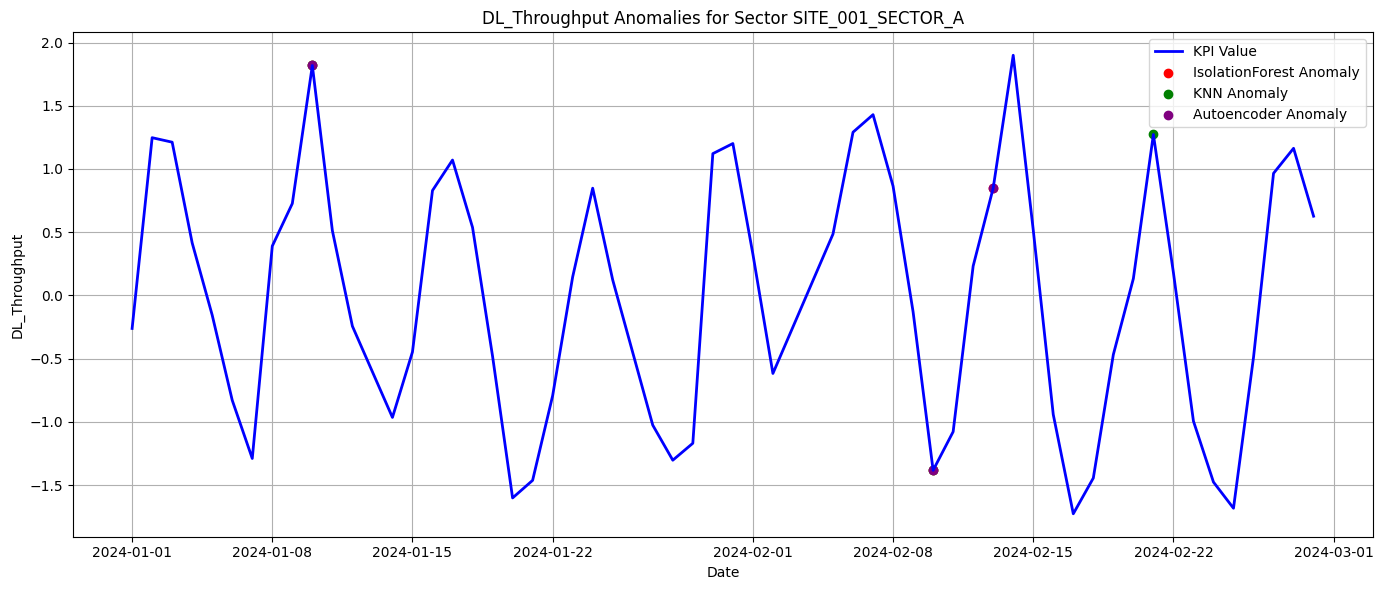

In [62]:
def plot_kpi_anomalies(df_scaled, consensus_results, sector_id, kpi):
    sector_data = df_scaled[df_scaled['Sector_ID'] == sector_id].copy()
    sector_data = sector_data.sort_values('Date')
    sector_data['Date'] = pd.to_datetime(sector_data['Date'])

    scores = consensus_results[kpi].loc[sector_data.index]

    anomalies = {}
    for model_name in ['IsolationForest', 'KNN', 'Autoencoder']:
        threshold = np.percentile(scores[model_name], 95)
        anomalies[model_name] = scores[model_name] >= threshold

    plt.figure(figsize=(14, 6))
    plt.plot(sector_data['Date'], sector_data[kpi], label='KPI Value', color='blue', linewidth=2)

    colors = {'IsolationForest': 'red', 'KNN': 'green', 'Autoencoder': 'purple'}
    for model_name, mask in anomalies.items():
        plt.scatter(sector_data['Date'][mask], sector_data[kpi][mask],
                    label=f'{model_name} Anomaly', color=colors[model_name], marker='o')

    plt.title(f"{kpi} Anomalies for Sector {sector_id}")
    plt.xlabel("Date")
    plt.ylabel(kpi)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_kpi_anomalies(df_scaled, consensus_results, "SITE_001_SECTOR_A", "DL_Throughput")

In [71]:
import pickle

with open("consensus_results.pkl", "wb") as f:
    pickle.dump(consensus_results, f)

In [72]:
df_scaled.to_csv('KPI_data_preprocessed.csv')